In [1]:
# Import library and modules

import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [3]:
# Load dataset

# index_col='month' → Sets the 'month' column as the index of the DataFrame.
# parse_dates=True → Converts the 'month' column into a datetime format instead of treating it as a regular string.

df = pd.read_csv('airline-passengers.csv', index_col='month', parse_dates=True)

df

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [4]:
df.shape

(144, 1)

In [5]:
df.head()

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


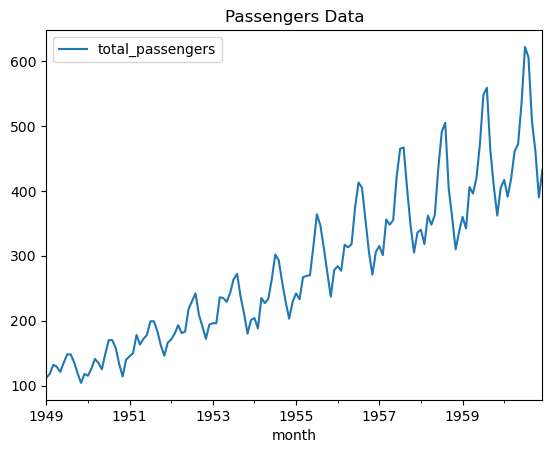

In [6]:
# Plot of the total passenger

df[['total_passengers']].plot(title='Passengers Data')

plt.show()

In [7]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

In [8]:
# The index consists of datetime values, but the frequency (freq) is not set. 
# To ensure the data is recognized as monthly, we should explicitly define the frequency as 'MS' (Month Start).

df.index.freq = "MS"

In [9]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq='MS')

In [10]:
# Define train and test dataset

train = df[:120]

test = df[120:]

#### 1) Single Exponential Smoothing- SES MODEL

In [11]:
# Hyperparameter Optimization


def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae


In [12]:
## How to determine alpha
#We can determine how much alpha will increase within a specific range. 0.01-1 increase- 0.10

alphas = np.arange(0.01, 1, 0.10)


In [13]:
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)

alpha: 0.01 mae: 225.5863
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


##### FIT THE MODEL

In [15]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)

y_pred = ses_model.forecast(24)

##### Plot SES MODEL 

In [16]:
def plot_prediction(y_pred, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

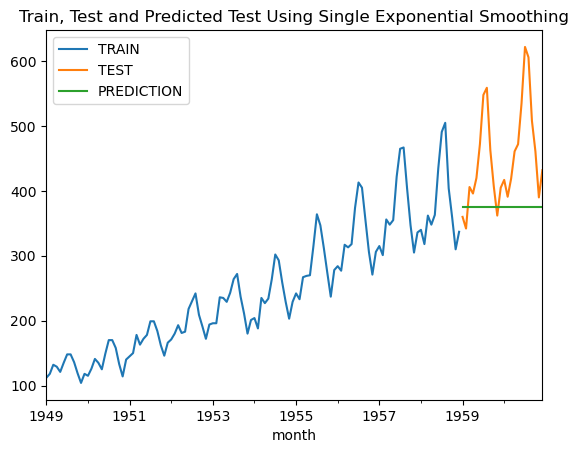

In [17]:
plot_prediction(y_pred, "Single Exponential Smoothing")

#### 2) Double Exponential Smoothing (DES)

In [19]:
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


In [20]:
alphas = np.arange(0.01, 1, 0.10)

betas = np.arange(0.01, 1, 0.10)

In [21]:
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)

alpha: 0.01 beta: 0.01 mae: 54.9512
alpha: 0.01 beta: 0.11 mae: 54.1036
alpha: 0.01 beta: 0.21 mae: 55.5568
alpha: 0.01 beta: 0.31 mae: 57.3247
alpha: 0.01 beta: 0.41 mae: 57.7931
alpha: 0.01 beta: 0.51 mae: 57.9968
alpha: 0.01 beta: 0.61 mae: 57.9636
alpha: 0.01 beta: 0.71 mae: 57.5635
alpha: 0.01 beta: 0.81 mae: 57.3334
alpha: 0.01 beta: 0.91 mae: 57.8984
alpha: 0.11 beta: 0.01 mae: 55.0309
alpha: 0.11 beta: 0.11 mae: 58.4728
alpha: 0.11 beta: 0.21 mae: 69.6339
alpha: 0.11 beta: 0.31 mae: 72.555
alpha: 0.11 beta: 0.41 mae: 78.8168
alpha: 0.11 beta: 0.51 mae: 81.996
alpha: 0.11 beta: 0.61 mae: 77.2262
alpha: 0.11 beta: 0.71 mae: 71.5042
alpha: 0.11 beta: 0.81 mae: 69.0258
alpha: 0.11 beta: 0.91 mae: 67.8408
alpha: 0.21 beta: 0.01 mae: 57.1824
alpha: 0.21 beta: 0.11 mae: 74.992
alpha: 0.21 beta: 0.21 mae: 95.9492
alpha: 0.21 beta: 0.31 mae: 115.3164
alpha: 0.21 beta: 0.41 mae: 139.4303
alpha: 0.21 beta: 0.51 mae: 178.3759
alpha: 0.21 beta: 0.61 mae: 243.4543
alpha: 0.21 beta: 0.71 mae:

##### FIT THE MODEL

In [22]:
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(24)

##### PLOT DES 

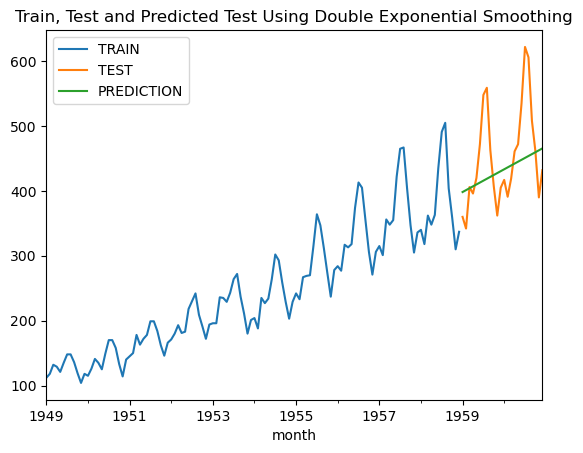

In [23]:
plot_prediction(y_pred, "Double Exponential Smoothing")

#### 3) Triple Exponential Smoothing (Holt-Winters)

In [24]:
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [25]:

alphas = betas = gammas = np.arange(0.10, 1, 0.20)

abg = list(itertools.product(alphas, betas, gammas))

In [26]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

[0.1, 0.1, 0.1, 36.83]
[0.1, 0.1, 0.3, 34.88]
[0.1, 0.1, 0.5, 35.91]
[0.1, 0.1, 0.7, 38.72]
[0.1, 0.1, 0.9, 42.55]
[0.1, 0.3, 0.1, 53.96]
[0.1, 0.3, 0.3, 53.0]
[0.1, 0.3, 0.5, 56.98]
[0.1, 0.3, 0.7, 61.38]
[0.1, 0.3, 0.9, 67.17]
[0.1, 0.5, 0.1, 56.77]
[0.1, 0.5, 0.3, 51.72]
[0.1, 0.5, 0.5, 53.39]
[0.1, 0.5, 0.7, 60.08]
[0.1, 0.5, 0.9, 79.29]
[0.1, 0.7, 0.1, 34.04]
[0.1, 0.7, 0.3, 25.93]
[0.1, 0.7, 0.5, 27.81]
[0.1, 0.7, 0.7, 27.91]
[0.1, 0.7, 0.9, 38.32]
[0.1, 0.9, 0.1, 26.87]
[0.1, 0.9, 0.3, 25.32]
[0.1, 0.9, 0.5, 53.88]
[0.1, 0.9, 0.7, 38.38]
[0.1, 0.9, 0.9, 17.78]
[0.3, 0.1, 0.1, 54.54]
[0.3, 0.1, 0.3, 38.34]
[0.3, 0.1, 0.5, 31.57]
[0.3, 0.1, 0.7, 30.99]
[0.3, 0.1, 0.9, 29.23]
[0.3, 0.3, 0.1, 72.71]
[0.3, 0.3, 0.3, 22.6]
[0.3, 0.3, 0.5, 11.99]
[0.3, 0.3, 0.7, 17.11]
[0.3, 0.3, 0.9, 22.32]
[0.3, 0.5, 0.1, 132.33]
[0.3, 0.5, 0.3, 25.74]
[0.3, 0.5, 0.5, 17.3]
[0.3, 0.5, 0.7, 38.38]
[0.3, 0.5, 0.9, 56.82]
[0.3, 0.7, 0.1, 288.32]
[0.3, 0.7, 0.3, 134.86]
[0.3, 0.7, 0.5, 96.77]
[0.3, 0.7, 

##### FIT THE MODEL

In [27]:
tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

In [28]:
y_pred = tes_model.forecast(24)

##### PLOT THE TES MODEL

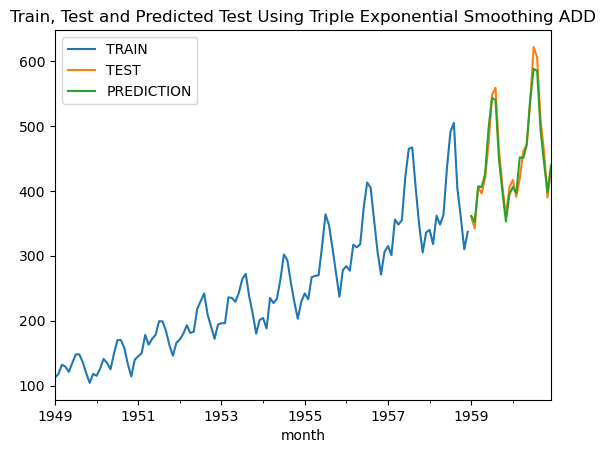

In [29]:
plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

#### 4) ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [30]:
p = d = q = range(0, 4)

pdq = list(itertools.product(p, d, q))

In [31]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print(f'ARIMA{order} AIC={aic:.2f}')
        except Exception as e:
            print(f"ARIMA{order} give an error : {e}")
            continue
    print(f'Best ARIMA{best_params} AIC={best_aic:.2f}')
    return best_params


In [32]:
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=1436.33
ARIMA(0, 0, 1) AIC=1295.42
ARIMA(0, 0, 2) AIC=1229.22
ARIMA(0, 0, 3) AIC=1169.78
ARIMA(0, 1, 0) AIC=1138.81
ARIMA(0, 1, 1) AIC=1127.02
ARIMA(0, 1, 2) AIC=1126.97
ARIMA(0, 1, 3) AIC=1125.45
ARIMA(0, 2, 0) AIC=1171.65
ARIMA(0, 2, 1) AIC=1136.52
ARIMA(0, 2, 2) AIC=1124.36
ARIMA(0, 2, 3) AIC=1124.57
ARIMA(0, 3, 0) AIC=1263.95
ARIMA(0, 3, 1) AIC=1169.49
ARIMA(0, 3, 2) AIC=1140.39
ARIMA(0, 3, 3) AIC=1127.31
ARIMA(1, 0, 0) AIC=1152.40
ARIMA(1, 0, 1) AIC=1138.85
ARIMA(1, 0, 2) AIC=1140.24
ARIMA(1, 0, 3) AIC=1142.18
ARIMA(1, 1, 0) AIC=1130.66
ARIMA(1, 1, 1) AIC=1125.43
ARIMA(1, 1, 2) AIC=1118.10
ARIMA(1, 1, 3) AIC=1119.79
ARIMA(1, 2, 0) AIC=1168.21
ARIMA(1, 2, 1) AIC=1127.97
ARIMA(1, 2, 2) AIC=1122.89
ARIMA(1, 2, 3) AIC=1123.66
ARIMA(1, 3, 0) AIC=1232.81
ARIMA(1, 3, 1) AIC=1166.48
ARIMA(1, 3, 2) AIC=1170.58
ARIMA(1, 3, 3) AIC=1130.67
ARIMA(2, 0, 0) AIC=1141.99
ARIMA(2, 0, 1) AIC=1138.37
ARIMA(2, 0, 2) AIC=1138.68
ARIMA(2, 0, 3) AIC=1135.89
ARIMA(2, 1, 0) AIC=1126.84
A

##### FIT THE MODEL

In [34]:
arima_model = ARIMA(train, order=best_params_aic).fit()

In [37]:
y_pred = arima_model.forecast(steps=24)

In [38]:
y_pred

1959-01-01    362.911666
1959-02-01    351.906173
1959-03-01    384.230188
1959-04-01    388.935759
1959-05-01    413.965592
1959-06-01    414.414763
1959-07-01    421.769789
1959-08-01    410.584451
1959-09-01    403.785333
1959-10-01    388.233058
1959-11-01    380.096650
1959-12-01    371.577482
1960-01-01    371.942540
1960-02-01    374.479660
1960-03-01    382.783013
1960-04-01    390.624929
1960-05-01    398.915247
1960-06-01    403.337731
1960-07-01    404.982390
1960-08-01    402.361287
1960-09-01    397.696402
1960-10-01    391.497202
1960-11-01    386.157218
1960-12-01    382.355649
Freq: MS, Name: predicted_mean, dtype: float64

In [39]:
mean_absolute_error(test, y_pred)

64.01186691700362

In [40]:
# Convert predictions to a pandas Series

y_pred = pd.Series(y_pred, index=test.index)

##### PLOT ARIMA

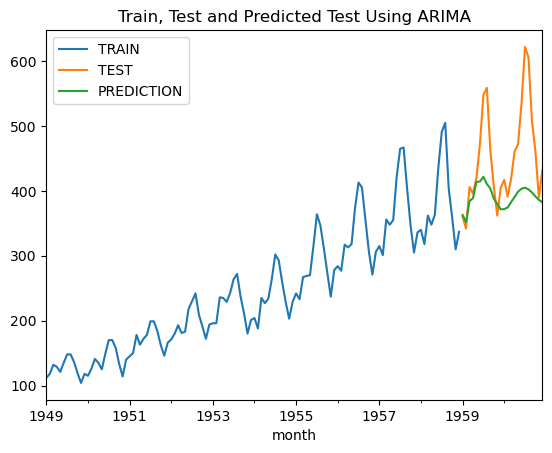

In [42]:
plot_prediction(y_pred, "ARIMA")

#### 5) SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)

In [44]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [45]:
## This function optimizes SARIMA model hyperparameters by selecting the best (p, d, q) and (P, D, Q, s) combination 
# that minimizes the Akaike Information Criterion (AIC).

def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    # Step 1: Initialize variables to store the best model parameters and AIC score
    best_aic, best_order, best_seasonal_order = float("inf"), None, None

    # Step 2: Iterate over all combinations of (p, d, q)
    for param in pdq:
        # Step 3: Iterate over all combinations of (P, D, Q, s)
        for param_seasonal in seasonal_pdq:
            try:
                # Step 4: Define and fit the SARIMA model with given parameters
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit()

                # Step 5: Get the AIC score of the fitted model
                aic = results.aic

                # Step 6: Update the best model parameters if the AIC score is lower
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal

                # Step 7: Print the current model parameters and its AIC score
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))

            # Step 8: Skip the iteration if an error occurs (e.g., model fails to fit)
            except:
                continue

    # Step 9: Print the best model parameters found
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))

    # Step 10: Return the best parameter set
    return best_order, best_seasonal_order


In [46]:
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1680.2792351899682
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1557.6320524366079
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1060.4792883426737
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1014.0696747520251
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1231.9865854042587
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1185.3010979087635
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:969.3781382611411
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:951.6205860640462
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1524.3620853405278
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1403.5942350302312
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:967.5225695583988
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:942.2425093047184
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1136.4998829516262
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1127.8397013702995
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:918.2233876020534
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:896.7057420760125
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1138.8088994229254
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC

In [47]:
best_order

(1, 1, 0)

In [48]:
best_seasonal_order

(0, 1, 0, 12)

##### FIT THE MODEL

In [49]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)

sarima_final_model = model.fit()

y_pred_test = sarima_final_model.get_forecast(steps=24)

In [50]:
y_pred = y_pred_test.predicted_mean

In [51]:
mean_absolute_error(test, y_pred)

68.57726545235921

In [52]:
y_pred = pd.Series(y_pred, index=test.index)

#### PLOT SARIMA MODEL

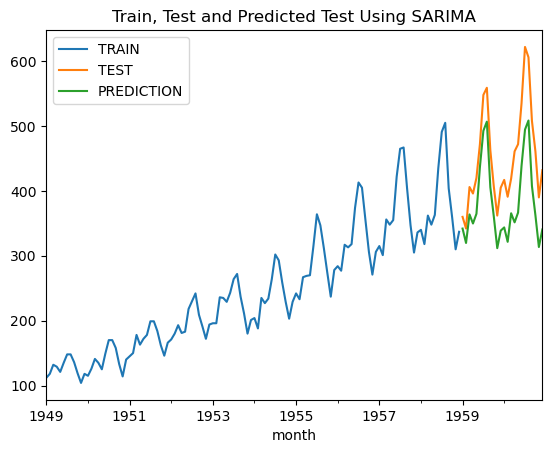

In [53]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

#### 6) SARIMA Optimization Based on **MAE**

In [55]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [58]:
# This function finds the best SARIMA model based on the Mean Absolute Error (MAE) instead of AIC. 
# It systematically evaluates different hyperparameter combinations and selects the one with the lowest MAE.

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    # Step 1: Initialize variables to store the best model parameters and lowest MAE score
    best_mae, best_order, best_seasonal_order = float("inf"), None, None

    # Step 2: Iterate over all combinations of (p, d, q)
    for param in pdq:
        # Step 3: Iterate over all combinations of (P, D, Q, s)
        for param_seasonal in seasonal_pdq:
            try:
                # Step 4: Define and fit the SARIMA model with given parameters
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit()

                # Step 5: Forecast the next 48 time steps
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean

                # Step 6: Calculate MAE (Mean Absolute Error) between actual and predicted values
                mae = mean_absolute_error(test, y_pred)

                # Step 7: Update the best model parameters if the MAE is lower
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal

                # Step 8: Print the current model parameters and its MAE score
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))

            # Step 9: Skip the iteration if an error occurs (e.g., model fails to fit)
            except:
                continue

    # Step 10: Print the best model parameters found
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))

    # Step 11: Return the best parameter set
    return best_order, best_seasonal_order


In [59]:
best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:452.25
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:367.20954586119325
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:71.25
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:72.62972633862401
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:74.93612753940359
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:76.79707192852042
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:58.599738739791015
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.597978671797723
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:442.6732363260505
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:356.28978571119933
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:70.49252848330782
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:71.32051673428833
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:75.4844936553633
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:76.43336614158902
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:61.0138855334626
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:31.738232164985945
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:115.25
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:119.36368447774557
SARIMA(0, 1, 0)x(0, 1,

In [60]:
best_order

(0, 0, 0)

In [61]:
best_seasonal_order

(1, 1, 1, 12)

##### FIT THE MODEL

In [62]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)

sarima_final_model = model.fit()

y_pred_test = sarima_final_model.get_forecast(steps=24)

y_pred = y_pred_test.predicted_mean

In [63]:
mean_absolute_error(test, y_pred)

30.597978671797723

In [64]:
y_pred = pd.Series(y_pred, index=test.index)

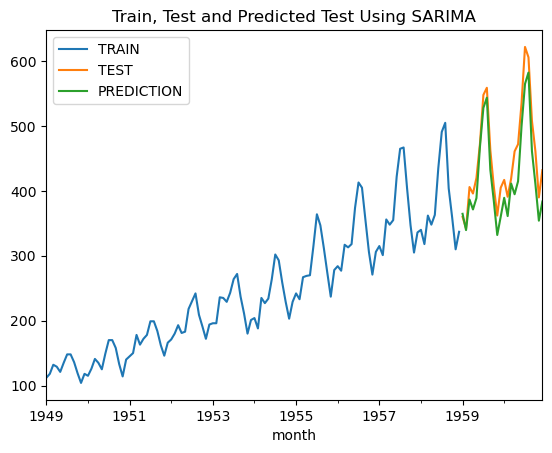

In [65]:
plot_prediction(y_pred, "SARIMA")

**SES best_mae**: 82.528

**DES best_mae**: 54.1036

**TES best_mae**: 11.9947

**ARIMA  best_mae** 64.011

**SARIMA best mae** 68.57

**SARIMA Optimization Based on MAE**  30.59

**TES provided the best estimate among the methods we have used.**

### 7) FINAL MODEL FOR ENTIRE DATASET BASED ON **TES**

In [66]:
tes_model_final = ExponentialSmoothing(df, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)


In [68]:
df

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [67]:
tes_model_final.forecast(6)


1961-01-01    450.286328
1961-02-01    429.302014
1961-03-01    475.721707
1961-04-01    502.017555
1961-05-01    516.825558
1961-06-01    579.037167
Freq: MS, dtype: float64